## Learning diffusivity (m) to solution (u) map for Poisson problem (Implementation 2)

Data is located in `../data` directory, and key data of our interest is in `Poisson_samples.npz` file. We would also need the mesh data in files with names `Poisson_m_mesh` and `Poisson_u_mesh` for plotting.

### Results
Below shows the neural operator prediction for different samples of test input. 

<p align="center"> <img src="Results_implement2/neural_operator_prediction_comparison.png" width="800"> </p>

In [2]:
import sys
import os
import time

import torch
import numpy as np

import dolfin as dl

util_path = "../../../utilities/"
sys.path.append(util_path)
from plotUtilities import field_plot_fenics
from dataMethods import DataProcessor
from torch_pcanet import PCANet

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
data_folder = '../data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/Results_implement2/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Load data

In [4]:
num_train = 1900
num_test = 100

num_inp_fn_points = 2601 # number of grid points for the input function
num_out_fn_points = 2601 # number of evaluations points for the output function
num_Y_components = 2 # displacement field in 2D
num_inp_red_dim = 50 # number of reduced dimensions for the input data
num_out_red_dim = 50 # number of reduced dimensions for the output data
out_coordinate_dimension = 2 # domain for output function is 2D

# training hyperparameters
batch_size = 100
epochs = 1000
lr = 1.0e-3
act_fn = torch.relu

data_prefix = 'LinearElasticity'
data = DataProcessor(data_folder + data_prefix + '_samples.npz', num_train, num_test, num_inp_fn_points, num_out_fn_points, num_Y_components, num_inp_red_dim, num_out_red_dim)

train_data = {'X_train': data.X_train, 'X_trunk': data.X_trunk, 'Y_train': data.Y_train}
test_data = {'X_train': data.X_test, 'X_trunk': data.X_trunk, 'Y_train': data.Y_test}

print('X_train:',data.X_train.shape)
print('Y_train:',data.Y_train.shape)
print('X_test:',data.X_test.shape)
print('Y_test:',data.Y_test.shape)
print('X_trunk:',data.X_trunk.shape)

print('X_train_svd_projector:',data.X_train_svd_projector.shape)
print('Y_train_svd_projector:',data.Y_train_svd_projector.shape)

X_train: (1900, 50)
Y_train: (1900, 50)
X_test: (100, 50)
Y_test: (100, 50)
X_trunk: (2601, 2)
X_train_svd_projector: (50, 2601)
Y_train_svd_projector: (50, 5202)


### Plot singular values

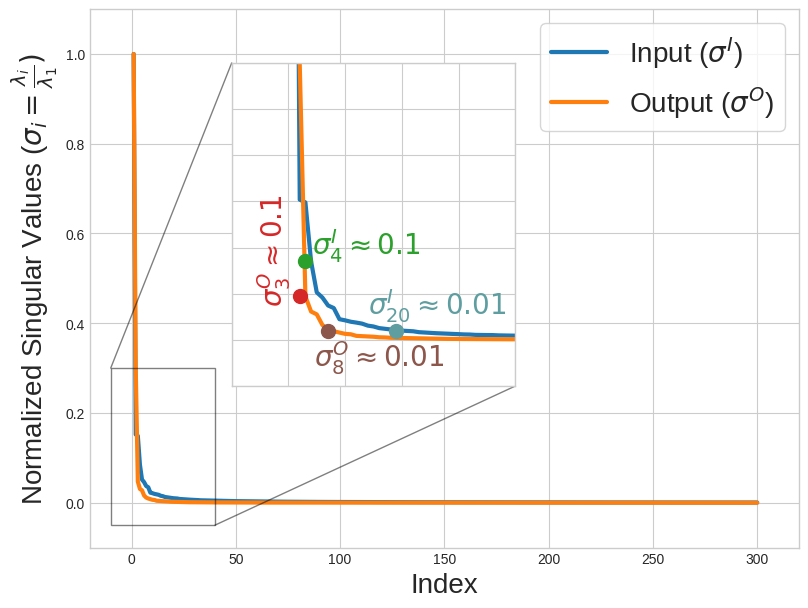

In [5]:
def locate_index(data, val = 0.1):
    idx = (np.abs(data - val)).argmin()
    return idx, data[idx]

def plot_s_values():
    in_s, out_s = data.X_train_s_values, data.Y_train_s_values

    n_min_max = len(in_s) if len(in_s) <= len(out_s) else len(out_s)
    N = 300 if n_min_max >= 300 else n_min_max

    p_in_s = in_s[:N] / in_s[0]
    p_out_s = out_s[:N] / out_s[0]
    lf = 20
    lw = 3
    mkr = 10

    plt.style.use('seaborn-v0_8-whitegrid') # checking by running command 'plt.style.available'

    fig = plt.figure(figsize=(8, 6))
    ax = fig.gca()

    # input
    ax.plot(np.arange(1, N+1), p_in_s, color = 'tab:blue', label = r'Input ($\sigma^{I}$)', lw = lw)
    # output
    ax.plot(np.arange(1, N+1), p_out_s, color = 'tab:orange', label = r'Output ($\sigma^{O}$)', lw = lw)

    # get small region for inset
    x1, x2, y1, y2 = -10, 40, -0.05, 0.3  # subregion of the original image
    axins = ax.inset_axes(
        [0.2, 0.3, 0.4, 0.6],
        xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
    axins.plot(np.arange(1, N+1), p_in_s, color = 'tab:blue', lw = lw)
    axins.plot(np.arange(1, N+1), p_out_s, color = 'tab:orange', lw = lw)
    ax.indicate_inset_zoom(axins, edgecolor="black")

    # input annot
    val_vec = [0.1, 0.01]
    val_color = ['tab:green', 'cadetblue']
    xy_text_vec = [(5, 5), (-20, 12)]
    for i in range(2):
        val = val_vec[i]
        vclr = val_color[i]
        in_index, in_index_val = locate_index(p_in_s, val = val)
        axins.plot(in_index, in_index_val, marker = 'o', markersize = mkr, \
                markerfacecolor=  vclr, markeredgecolor = vclr)
        axins.annotate(r'$\sigma^{}_{{{}}} \approx {}$'.format('I', in_index + 1, val), \
                    xy=(in_index, in_index_val),
                    xytext=xy_text_vec[i], xycoords = 'data', \
                    textcoords='offset points', color = vclr, \
                    size = lf)

    # output annot
    val_color = ['tab:red', 'tab:brown']
    xy_text_vec = [(-32, 0), (-10, -25)]
    rot_vec = [90, 0]
    for i in range(2):
        val = val_vec[i]
        vclr = val_color[i]
        out_index, out_index_val = locate_index(p_out_s, val = val)
        axins.plot(out_index, out_index_val, marker = 'o', markersize = mkr, \
                markerfacecolor=  vclr, markeredgecolor = vclr)
        axins.annotate(r'$\sigma^{}_{{{}}} \approx {}$'.format('O', out_index + 1, val), \
                    xy=(out_index, out_index_val),
                    xytext=xy_text_vec[i], xycoords = 'data', \
                    textcoords='offset points', color = vclr, \
                    size = lf, rotation = rot_vec[i])


    ax.legend(fontsize = lf, fancybox = True, frameon = True)#, facecolor="gray")
    ax.set_xlabel(r'Index', fontsize = lf)
    ax.set_ylabel(r'Normalized Singular Values ($\sigma_i = \frac{\lambda_i}{\lambda_1})$', fontsize = lf)

    ax.set_ylim([-0.1, 1.1])
    ax.set_xlim([-20, 320])

    

    plt.tight_layout(pad=0.4)

    plt.savefig(results_dir + 'svd_analysis_ntrain.png')

    plt.show()

plot_s_values()

## Create model and train the network

In [6]:
num_layers = 4
num_neurons = 128
model = PCANet(num_layers, num_neurons, act_fn, num_inp_red_dim, num_out_red_dim)

In [7]:
# Train
model.train(train_data, test_data, batch_size=batch_size, epochs = epochs, lr = lr)

Epoch:     0, Train Loss (l2 squared): 9.030e+01, Test Loss (l2 squared): 8.989e+01, Time (sec): 0.102
Epoch:   100, Train Loss (l2 squared): 8.935e-02, Test Loss (l2 squared): 2.278e-01, Time (sec): 0.097
Epoch:   200, Train Loss (l2 squared): 5.147e-02, Test Loss (l2 squared): 1.825e-01, Time (sec): 0.074
Epoch:   300, Train Loss (l2 squared): 3.288e-02, Test Loss (l2 squared): 1.607e-01, Time (sec): 0.074
Epoch:   400, Train Loss (l2 squared): 2.513e-02, Test Loss (l2 squared): 1.440e-01, Time (sec): 0.074
Epoch:   500, Train Loss (l2 squared): 5.208e-02, Test Loss (l2 squared): 1.305e-01, Time (sec): 0.074
Epoch:   600, Train Loss (l2 squared): 1.480e-02, Test Loss (l2 squared): 1.149e-01, Time (sec): 0.074
Epoch:   700, Train Loss (l2 squared): 2.628e-02, Test Loss (l2 squared): 1.135e-01, Time (sec): 0.076
Epoch:   800, Train Loss (l2 squared): 1.244e-02, Test Loss (l2 squared): 1.044e-01, Time (sec): 0.074
Epoch:   900, Train Loss (l2 squared): 1.554e-02, Test Loss (l2 squared):

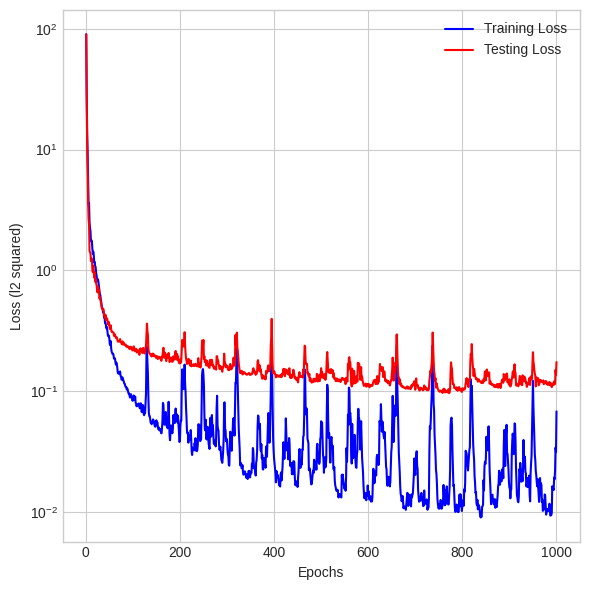

In [8]:
## Plotting the loss history
num_epoch = model.train_loss_log.shape[0]
x = np.linspace(1, num_epoch, num_epoch)
fig = plt.figure(constrained_layout=False, figsize=(6, 6))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0])
ax.plot(x, model.train_loss_log[:, 0], color='blue', label='Training Loss')
ax.plot(x, model.test_loss_log[:, 0], color='red', label='Testing Loss')
ax.set_yscale('log')
ax.set_ylabel('Loss (l2 squared)')
ax.set_xlabel('Epochs')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig(results_dir+'loss_his.png',  bbox_inches='tight')
plt.show()

## Test and plot the output of network

In [11]:
Y_test = test_data['Y_train']
Y_test_pred = model.predict(test_data).detach().numpy()

print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))

error = np.linalg.norm(Y_test - Y_test_pred, axis = 1)/np.linalg.norm(Y_test, axis = 1)

print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (100, 50), test_pred shape: (100, 50)
Num tests:   100, Mean Loss (rel l2): 4.221e-02, Std Loss (rel l2): 5.032e-02


In [12]:
def get_FE_space(mesh_file = data_folder + 'LinearElasticity_u_mesh.xdmf', is_vector = False):
    mesh = dl.Mesh()
    with dl.XDMFFile(mesh_file) as infile:
        infile.read(mesh)
    if is_vector:
        V = dl.VectorFunctionSpace(mesh, "Lagrange", 1)
    else:
        V = dl.FunctionSpace(mesh, "Lagrange", 1)
    return V

i_plot =    26, error (rel l2): 3.708e-03
i_plot =    86, error (rel l2): 3.373e-04
i_plot =     2, error (rel l2): 8.462e-04
i_plot =    55, error (rel l2): 6.920e-04
i_plot =    75, error (rel l2): 2.576e-03
i_plot =    93, error (rel l2): 2.611e-03
i_plot =    16, error (rel l2): 1.186e-03
i_plot =    73, error (rel l2): 9.096e-04
i_plot =    54, error (rel l2): 5.115e-03
i_plot =    95, error (rel l2): 7.141e-04
i_plot =    53, error (rel l2): 1.996e-02
i_plot =    92, error (rel l2): 3.367e-04
i_plot =    78, error (rel l2): 1.087e-03
i_plot =    13, error (rel l2): 1.133e-03
i_plot =     7, error (rel l2): 6.521e-03
i_plot =    30, error (rel l2): 1.580e-02


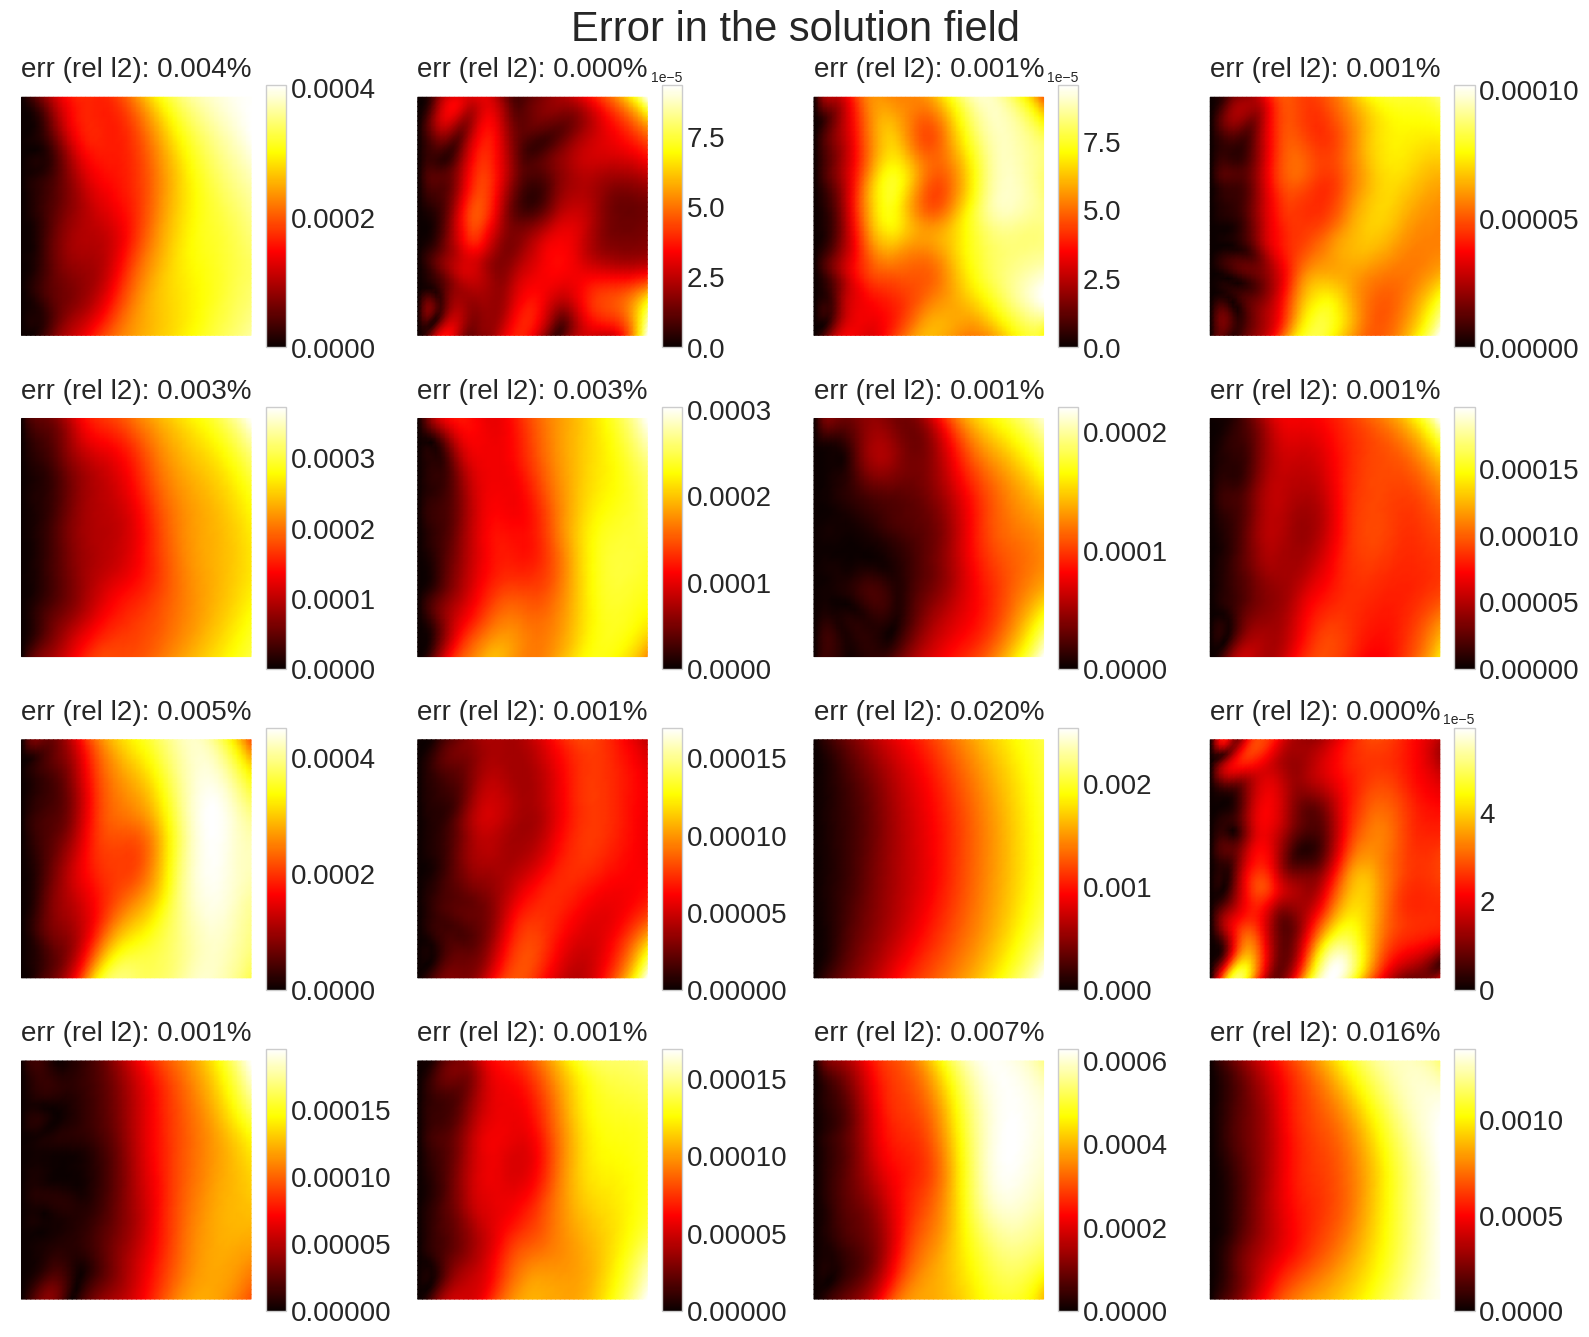

In [13]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True

Vu = get_FE_space(data_folder + data_prefix + '_u_mesh.xdmf', is_vector=True)
Vm = get_FE_space(data_folder + data_prefix + '_m_mesh.xdmf')

Y_spatial_points = data.X_trunk

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows*cols, replace=False)

for i in range(rows):
    for j in range(cols):
        i_plot = i_choices[i*cols + j]

        i_pred = Y_test_pred[i_plot]
        i_truth = Y_test[i_plot]
        if decode:
            i_pred = data.decoder_Y(i_pred)
            i_truth = data.decoder_Y(i_truth)

        i_diff = i_pred - i_truth
        i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
        print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

        nodes = Y_spatial_points

        cbar = field_plot_fenics(axs[i,j], i_diff.flatten(), \
                                     Vu, \
                                     cmap = 'hot', \
                                     add_displacement_to_nodes = False, \
                                     is_displacement = True)

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)
        fig.colorbar(cbar, cax=cax, orientation='vertical')

        err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm)
        axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Error in the solution field', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'sample_error_plots.png',  bbox_inches='tight')
plt.show()


i_plot =    18, error (rel l2): 1.148e-03
i_plot =    29, error (rel l2): 5.351e-04
i_plot =    64, error (rel l2): 5.642e-04
i_plot =    92, error (rel l2): 3.367e-04


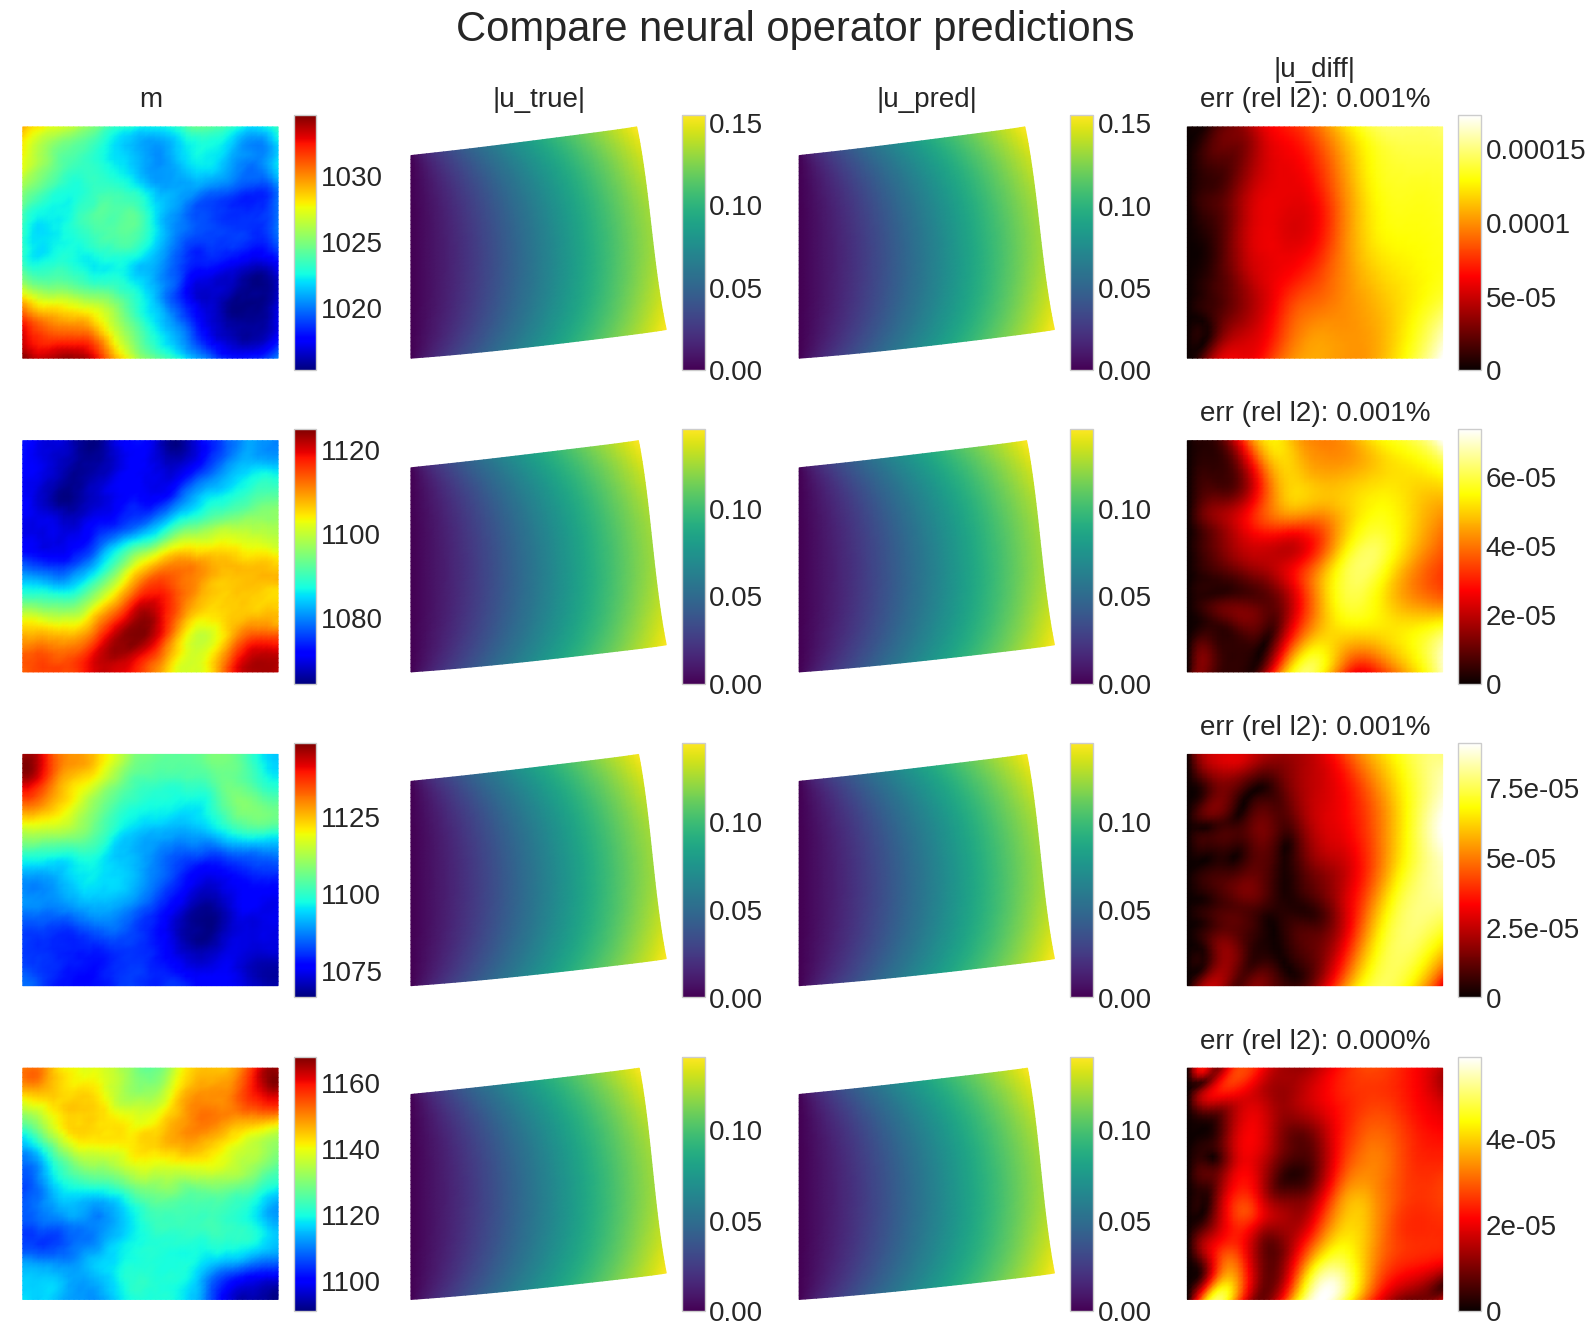

In [14]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True

Vu = get_FE_space(data_folder + data_prefix + '_u_mesh.xdmf', is_vector=True)
Vm = get_FE_space(data_folder + data_prefix + '_m_mesh.xdmf')

# row: m, u_true, u_pred, u_diff
u_tags = ['m', '|u_true|', '|u_pred|', '|u_diff|']
cmaps = ['jet', 'viridis', 'viridis', 'hot']
Vvec = [Vm, Vu, Vu, Vu]
Y_spatial_points = data.X_trunk # for this problem, nodes are same for m and u functions
X_spatial_points = Y_spatial_points

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):
    
    i_plot = i_choices[i]

    i_pred = Y_test_pred[i_plot]
    i_truth = Y_test[i_plot]
    i_m_test = data.X_test[i_plot]
    if decode:
        i_pred = data.decoder_Y(i_pred)
        i_truth = data.decoder_Y(i_truth)
        i_m_test = data.decoder_X(i_m_test)
            
    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
    print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

    uvec = [i_m_test, i_truth, i_pred, i_diff]
    
    for j in range(cols):
        nodes = Y_spatial_points if j > 0 else X_spatial_points
        
        if j == 0:
            cbar = field_plot_fenics(axs[i,j], uvec[j], Vvec[j], cmap = cmaps
            [j])
        elif j == cols - 1:
            cbar = field_plot_fenics(axs[i,j], uvec[j].flatten(), Vvec[j], \
                                     cmap = cmaps[j], \
                                     add_displacement_to_nodes = False,\
                                     is_displacement = True)
        else:
            cbar = field_plot_fenics(axs[i,j], uvec[j].flatten(), Vvec[j], \
                                     cmap = cmaps[j], \
                                     add_displacement_to_nodes = True,\
                                     is_displacement = True)

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j == 0 or j == cols - 1:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        if i == 0 and j < cols - 1:
            axs[i,j].set_title(u_tags[j], fontsize=fs)
        
        if j == cols - 1:
            err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm)
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Compare neural operator predictions', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'neural_operator_prediction_comparison.png',  bbox_inches='tight')
plt.show()
